In [9]:

import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)


In [15]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [12]:
df = pd.read_csv("/content/train.csv", encoding="latin-1")
test_df = pd.read_csv("/content/test.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))

df.head()

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


In [13]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271])

In [16]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [17]:
disaster_df = df[df['target'] == 1]['text_len'].value_counts().sort_index()
fake_df = df[df['target'] == 0]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=disaster_df.index,
    y=disaster_df.values,
    name='Real disaster',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=fake_df.index,
    y=fake_df.values,
    name='Fake',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.show()

In [18]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        '',
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)

    return text

In [19]:
# Test emoji removal
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [23]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [25]:
test_df['text_clean'] = test_df['text'].apply(preprocess_data)

df['text_clean'] = df['text'].apply(preprocess_data)
df.head()

,id,text,target,text_len,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


In [26]:
def create_corpus_df(tweet, target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [27]:
corpus_disaster_tweets = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('fire', 266),
 ('bomb', 179),
 ('kill', 158),
 ('news', 132),
 ('via', 121),
 ('flood', 120),
 ('disast', 116),
 ('california', 115),
 ('crash', 110),
 ('suicid', 110)]

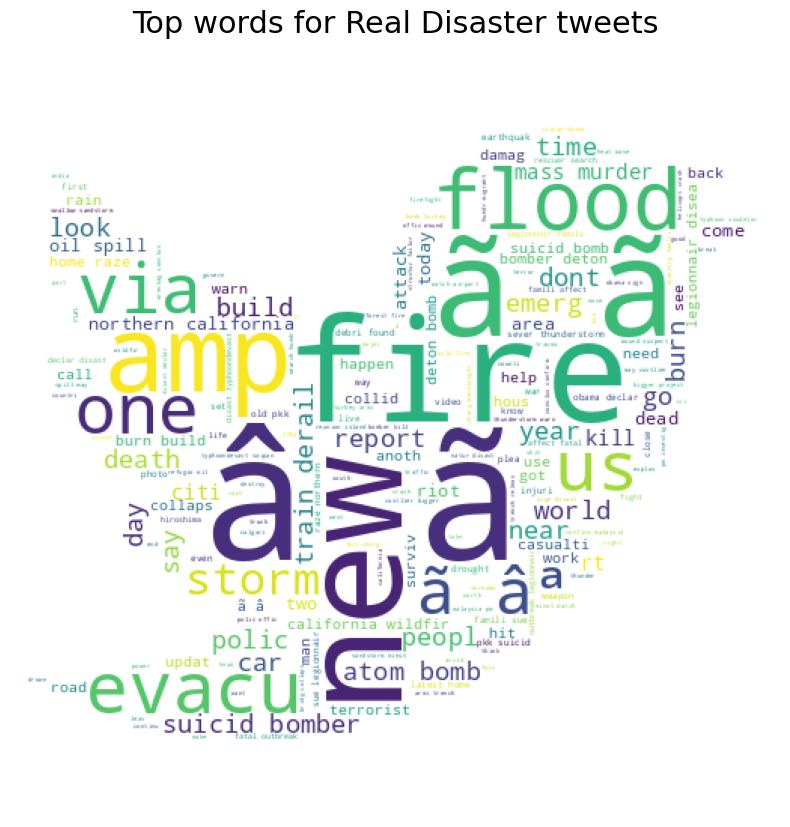

In [29]:
twitter_mask = np.array(Image.open('/content/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Real Disaster tweets',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [30]:
corpus_disaster_tweets = create_corpus_df(df, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top


[('like', 306),
 ('get', 222),
 ('amp', 192),
 ('new', 168),
 ('go', 142),
 ('dont', 139),
 ('one', 134),
 ('bodi', 116),
 ('love', 115),
 ('bag', 108)]

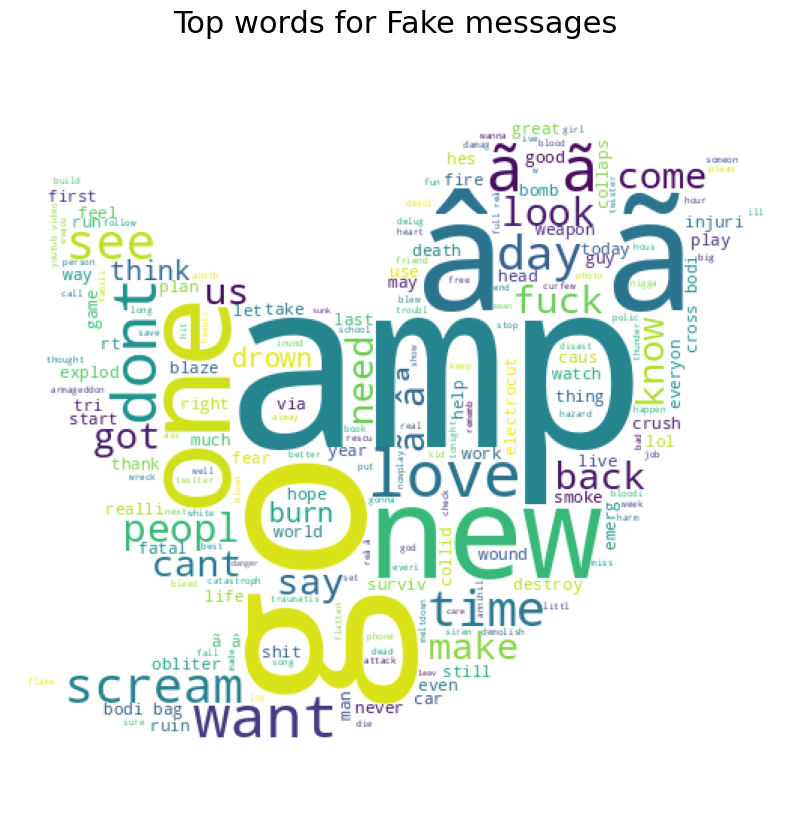

In [31]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [32]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['text_clean']
y = df['target']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [34]:
!pip install xgboost


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
import xgboost as xgb

# Определение конвейера (pipeline)
pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])

# Обучение конвейера на данных
pipe.fit(x_train, y_train)

# Предсказания на тестовом и обучающем наборе данных
y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

# Вывод метрик
print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))



Train: 0.861096514275705
Test: 0.773109243697479


In [44]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

[[961 130]
 [302 511]]


In [45]:
train_tweets = df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = df['target'].values

In [46]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13704

In [47]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

In [49]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [50]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets),
    length_long_sentence,
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 136,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1807, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2637, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

In [76]:
import numpy as np

embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/glove.6B.100d 2.txt') as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        try:
            vector_dimensions = np.asarray(records[1:], dtype='float32')
            embeddings_dictionary[word] = vector_dimensions
        except ValueError:
            print(f"Skipping line with word '{word}' due to conversion error.")

# Проверка количества загруженных эмбеддингов
print(f"Loaded {len(embeddings_dictionary)} word vectors.")


Loaded 6118 word vectors.


In [77]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [57]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    train_target,
    test_size=0.25
)

In [78]:

def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1370400   
                                                                 
 bidirectional (Bidirection  (None, 23, 46)            22816     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 46)                0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 46)                184       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 46)                0         
                                                        

In [121]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
179/179 [==============================] - ETA: 0s - loss: 0.8419 - accuracy: 0.5013
Epoch 1: val_loss improved from inf to 0.66668, saving model to model.h5
179/179 [==============================] - 37s 139ms/step - loss: 0.8419 - accuracy: 0.5013 - val_loss: 0.6667 - val_accuracy: 0.5903 - lr: 0.0010
Epoch 2/7
179/179 [==============================] - ETA: 0s - loss: 0.6508 - accuracy: 0.6355
Epoch 2: val_loss improved from 0.66668 to 0.60637, saving model to model.h5
179/179 [==============================] - 19s 105ms/step - loss: 0.6508 - accuracy: 0.6355 - val_loss: 0.6064 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 3/7
178/179 [============================>.] - ETA: 0s - loss: 0.6007 - accuracy: 0.6980
Epoch 3: val_loss improved from 0.60637 to 0.54282, saving model to model.h5
179/179 [==============================] - 9s 48ms/step - loss: 0.6011 - accuracy: 0.6977 - val_loss: 0.5428 - val_accuracy: 0.7715 - lr: 0.0010
Epoch 4/7
179/179 [==============================

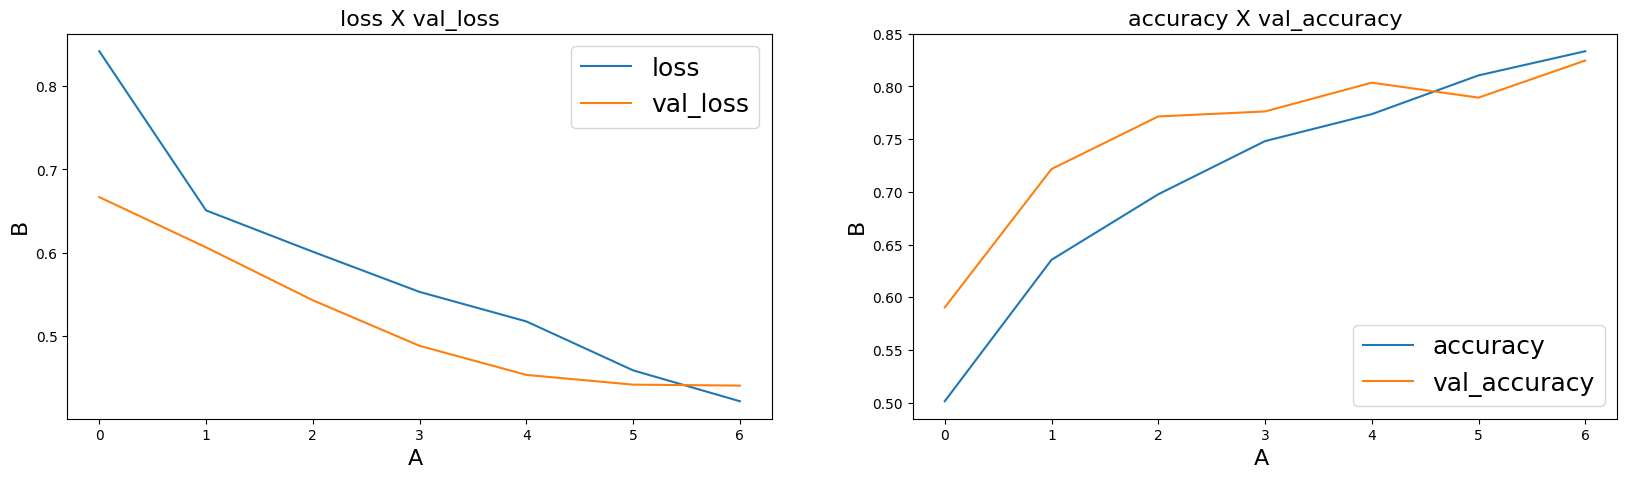

In [122]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])


In [134]:
print("Acuracy: ",f1_score(model.predict(X_test)>0.5, y_test))
print("Precision: ", precision_score(model.predict(X_test)>0.5, y_test))
print("Recall: ", recall_score(model.predict(X_test)>0.5, y_test))
print("Acuracy: ", accuracy_score(model.predict(X_test)>0.5, y_test))


60/60 [==============================] - 1s 16ms/step
Acuracy:  0.7712328767123288
60/60 [==============================] - 1s 15ms/step
Precision:  0.7181122448979592
60/60 [==============================] - 1s 19ms/step
Recall:  0.8328402366863905
60/60 [==============================] - 1s 19ms/step
Acuracy:  0.8245798319327731


In [95]:
import plotly.figure_factory as ff

x_axes = ['Fake', 'Real']
y_axes =  ['Real', 'Fake']

def conf_matrix(z, x=x_axes, y=y_axes):

    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True

    return fig

In [111]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
show_metrics(y_test,y_pred)

F1-score:  0.1391304347826087
Precision:  0.47058823529411764
Recall:  0.08163265306122448
Acuracy:  0.5840336134453782
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.94      0.73      1120
           1       0.47      0.08      0.14       784

    accuracy                           0.58      1904
   macro avg       0.53      0.51      0.43      1904
weighted avg       0.54      0.58      0.48      1904



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

